In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions,plot_xgb_feature_importance


In [4]:
sheet = pd.read_excel('data_input/RBOB汽油裂解价差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['RBOB汽油裂解价差（均价）'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=20, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,RBOB汽油裂解价差（均价）,全球经济惊喜指数（同花顺）超季节性/3年,美国纽约港93#汽油-欧洲Ebob汽油,美国首次申领失业金人数/4WMA,美国经济惊喜指数,美国2年期国债收益率60日环差,美国汽油库存(预测/移动平均同比)超季节性/5年,LME铜价/WTI原油期货价格,美国商业银行信用卡贷款SA（同花顺）4周环比
2025-12-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-05,NaN,NaN,NaN,NaN,NaN,NaN,-807.8493,NaN,NaN


In [5]:
sheet.columns

Index(['RBOB汽油裂解价差（均价）', '全球经济惊喜指数（同花顺）超季节性/3年', '美国纽约港93#汽油-欧洲Ebob汽油',
       '美国首次申领失业金人数/4WMA', '美国经济惊喜指数', '美国2年期国债收益率60日环差',
       '美国汽油库存(预测/移动平均同比)超季节性/5年', 'LME铜价/WTI原油期货价格',
       '美国商业银行信用卡贷款SA（同花顺）4周环比'],
      dtype='object')

In [6]:
################################# 处理缺失值 #################################
fill_methods = {
'全球经济惊喜指数（同花顺）超季节性/3年': 'interpolate',
'美国纽约港93#汽油-欧洲Ebob汽油': 'interpolate',     
'美国首次申领失业金人数/4WMA': 'interpolate', 
'美国经济惊喜指数': 'interpolate',
'美国2年期国债收益率60日环差': 'interpolate', 
'美国汽油库存(预测/移动平均同比)超季节性/5年': 'interpolate', 
'LME铜价/WTI原油期货价格': 'interpolate', 
'美国商业银行信用卡贷款SA（同花顺）4周环比': 'interpolate',
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
#sheet.loc[:last_day, 'LME铜价'] = sheet.loc[:last_day, 'LME铜价'].interpolate(method='linear')

#################################  因子处理  #################################
sheet['全球经济惊喜指数（同花顺）超季节性/3年_提前95天'] = sheet['全球经济惊喜指数（同花顺）超季节性/3年'].shift(95)
sheet['美国纽约港93#汽油-欧洲Ebob汽油_提前20天'] = sheet['美国纽约港93#汽油-欧洲Ebob汽油'].shift(20)
sheet['美国首次申领失业金人数/4WMA_提前50天'] = sheet['美国首次申领失业金人数/4WMA'].shift(50)
sheet['美国经济惊喜指数_提前95天'] = sheet['美国经济惊喜指数'].shift(95)
sheet['美国2年期国债收益率60日环差_提前100天'] = sheet['美国2年期国债收益率60日环差'].shift(100)
sheet['LME铜价/WTI原油期货价格_提前75天'] = sheet['LME铜价/WTI原油期货价格'].shift(75)
sheet['美国商业银行信用卡贷款SA（同花顺）4周环比_提前40天'] = sheet['美国商业银行信用卡贷款SA（同花顺）4周环比'].shift(40)


sheet['美国纽约港93#汽油-欧洲Ebob汽油_提前20天_逆序'] = reverse_column(sheet, '美国纽约港93#汽油-欧洲Ebob汽油_提前20天')
sheet['美国首次申领失业金人数/4WMA_提前50天_逆序'] = reverse_column(sheet, '美国首次申领失业金人数/4WMA_提前50天')
sheet['美国汽油库存(预测/移动平均同比)超季节性/5年_逆序'] = reverse_column(sheet, '美国汽油库存(预测/移动平均同比)超季节性/5年')
sheet['LME铜价/WTI原油期货价格_提前75天_逆序'] = reverse_column(sheet, 'LME铜价/WTI原油期货价格_提前75天')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['RBOB汽油裂解价差（均价）'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [7]:
sheet_daily.columns

Index(['Date', 'RBOB汽油裂解价差（均价）', '全球经济惊喜指数（同花顺）超季节性/3年', '美国纽约港93#汽油-欧洲Ebob汽油',
       '美国首次申领失业金人数/4WMA', '美国经济惊喜指数', '美国2年期国债收益率60日环差',
       '美国汽油库存(预测/移动平均同比)超季节性/5年', 'LME铜价/WTI原油期货价格', '美国商业银行信用卡贷款SA（同花顺）4周环比',
       '全球经济惊喜指数（同花顺）超季节性/3年_提前95天', '美国纽约港93#汽油-欧洲Ebob汽油_提前20天',
       '美国首次申领失业金人数/4WMA_提前50天', '美国经济惊喜指数_提前95天', '美国2年期国债收益率60日环差_提前100天',
       'LME铜价/WTI原油期货价格_提前75天', '美国商业银行信用卡贷款SA（同花顺）4周环比_提前40天',
       '美国纽约港93#汽油-欧洲Ebob汽油_提前20天_逆序', '美国首次申领失业金人数/4WMA_提前50天_逆序',
       '美国汽油库存(预测/移动平均同比)超季节性/5年_逆序', 'LME铜价/WTI原油期货价格_提前75天_逆序'],
      dtype='object')

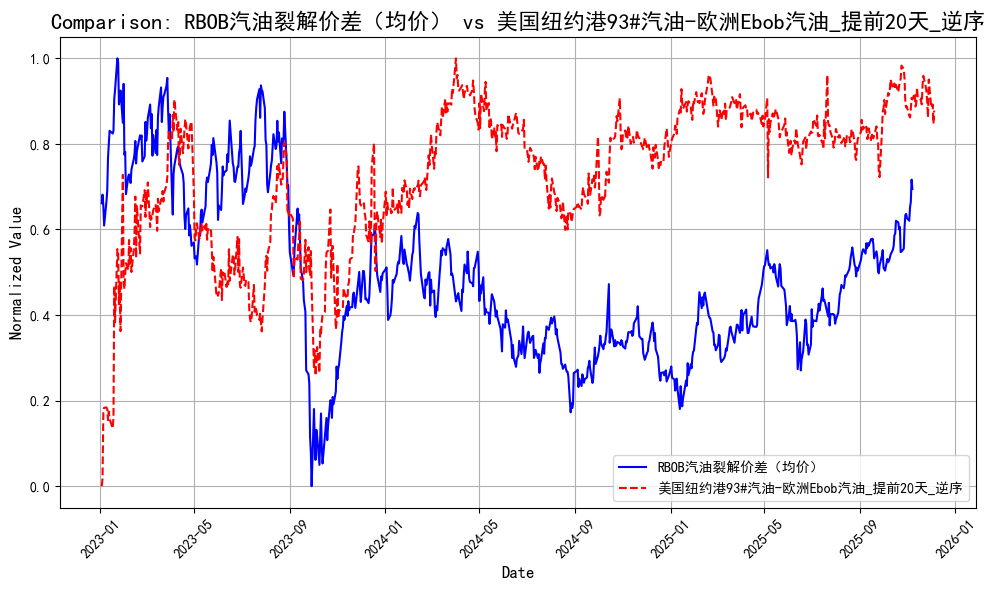

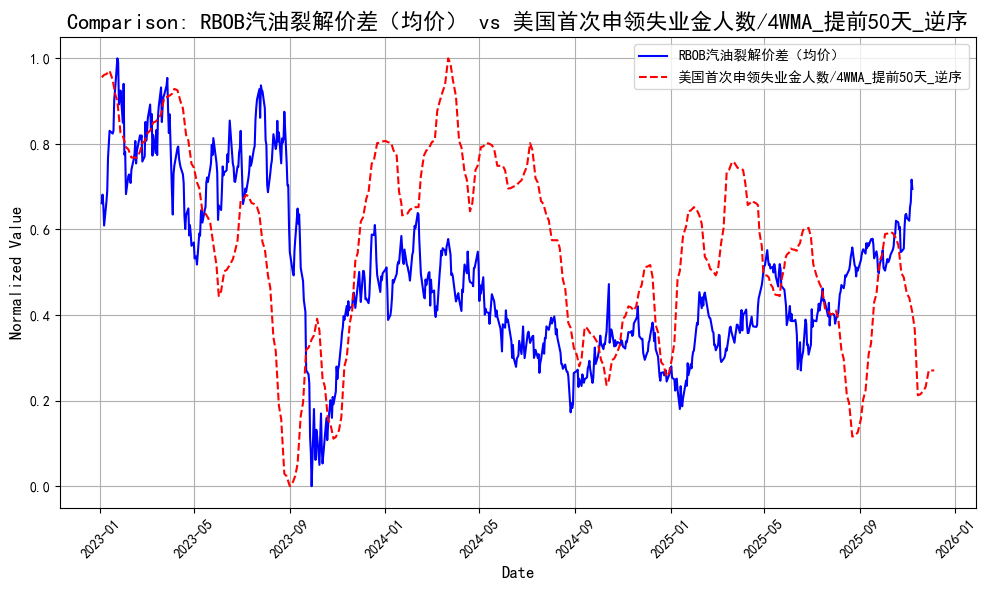

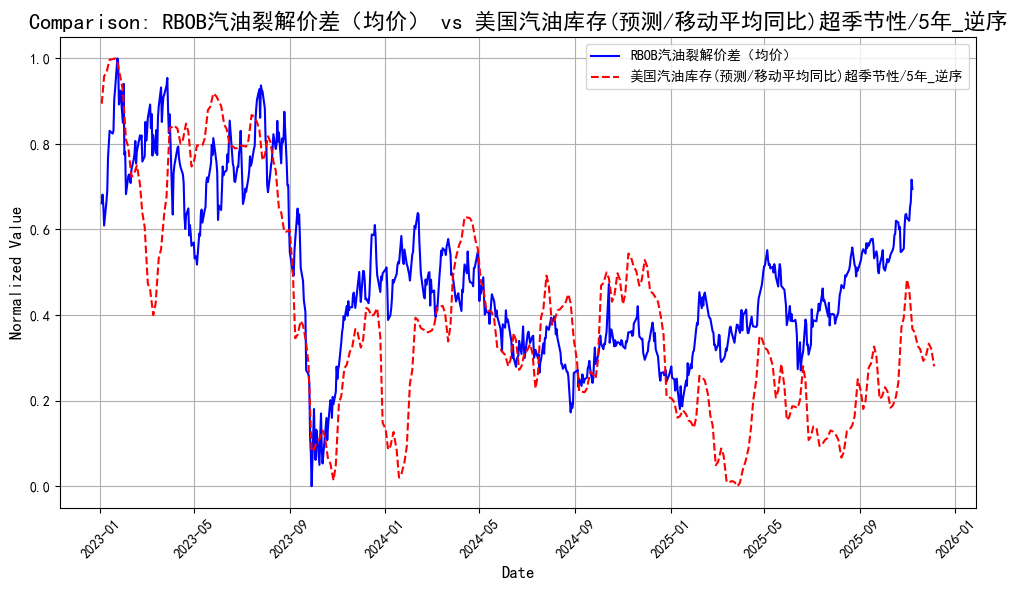

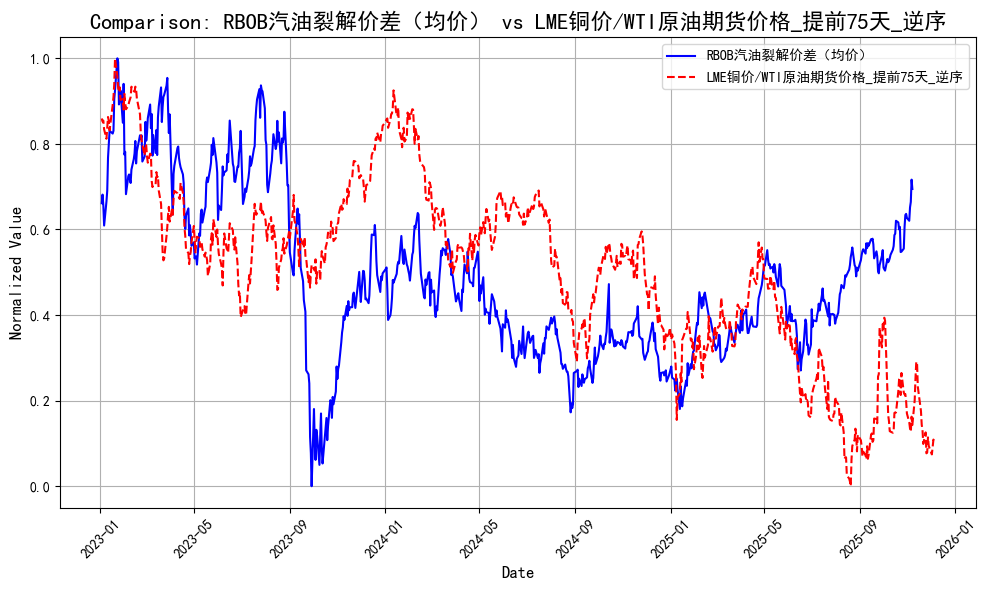

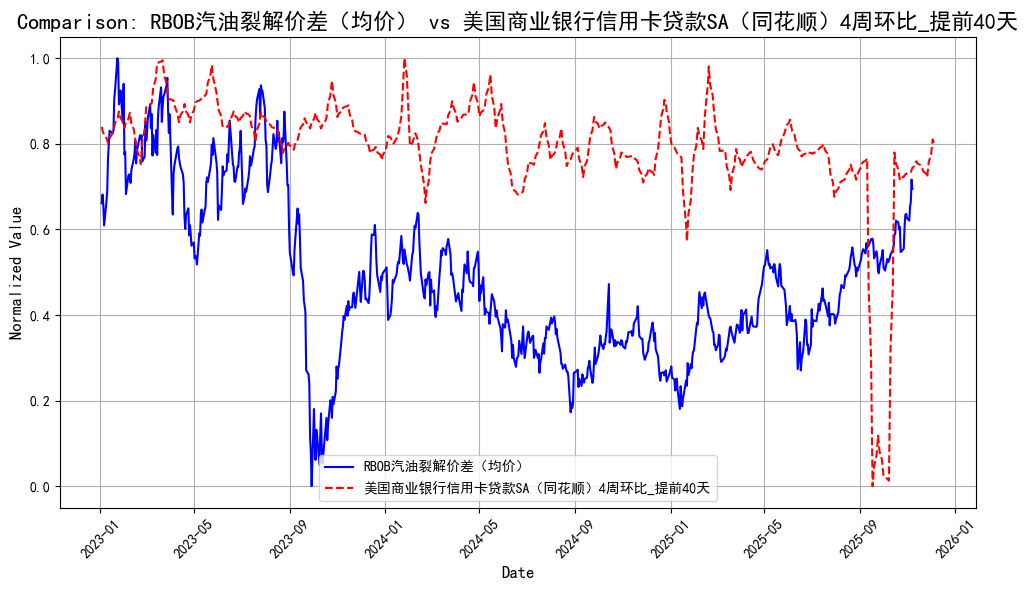

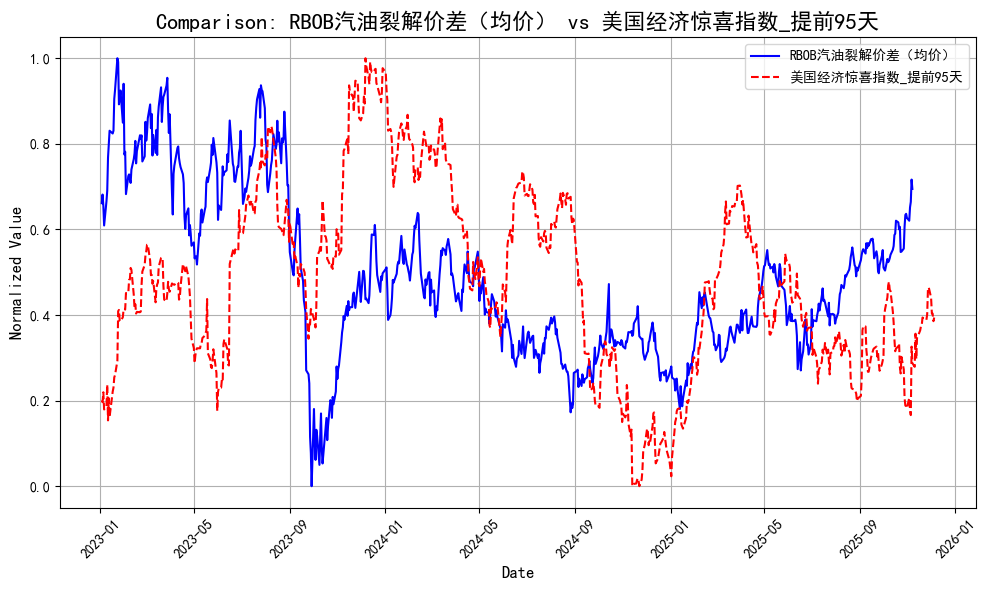

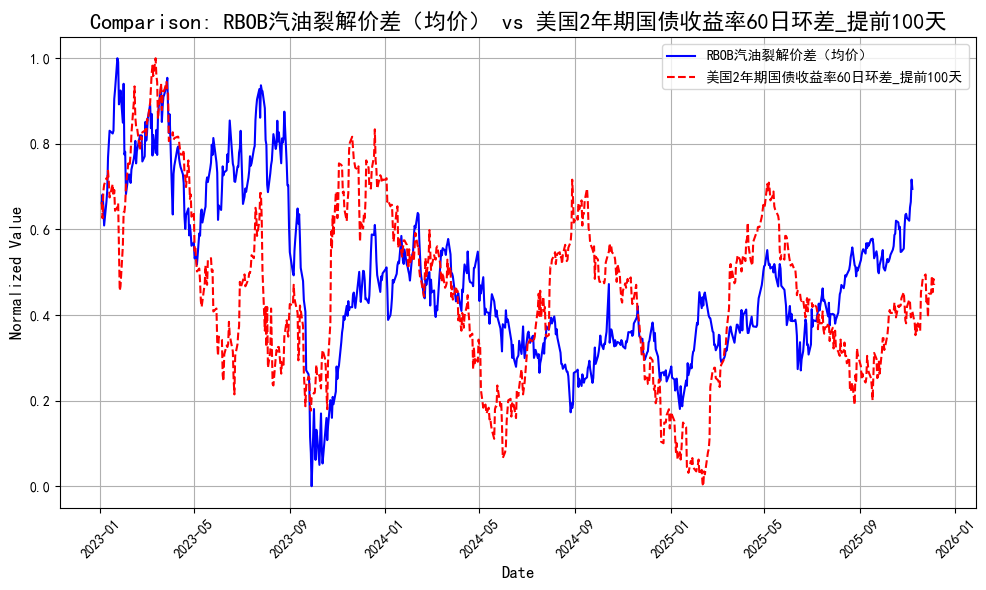

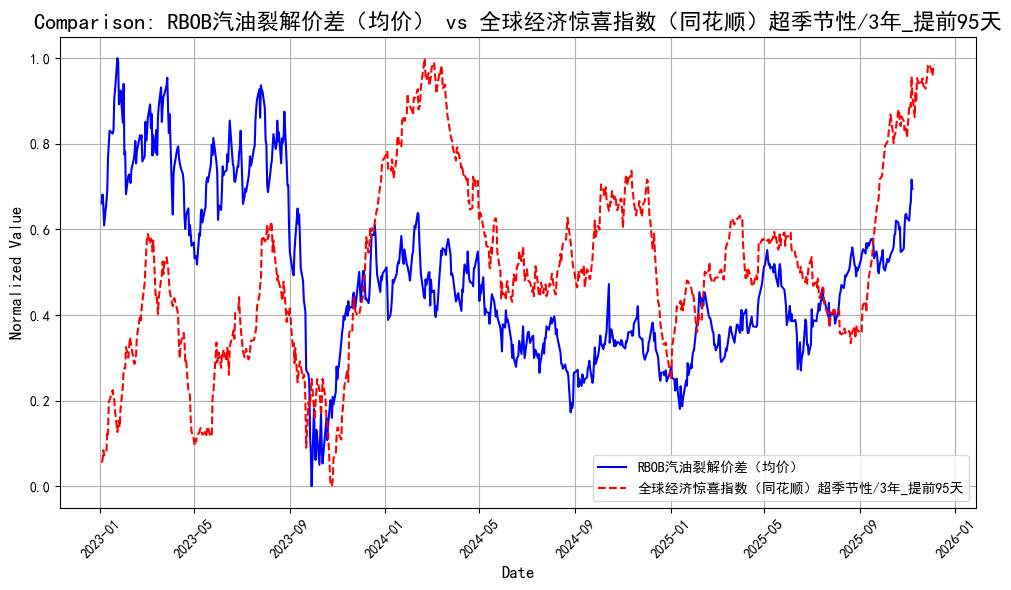

In [8]:
sheet_daily_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    sheet_daily_plot, 
    main_col='RBOB汽油裂解价差（均价）', 
    compare_cols=[
        '美国纽约港93#汽油-欧洲Ebob汽油_提前20天_逆序', 
        '美国首次申领失业金人数/4WMA_提前50天_逆序',
       '美国汽油库存(预测/移动平均同比)超季节性/5年_逆序',
         'LME铜价/WTI原油期货价格_提前75天_逆序',
         '美国商业银行信用卡贷款SA（同花顺）4周环比_提前40天',
         '美国经济惊喜指数_提前95天', 
         '美国2年期国债收益率60日环差_提前100天',
         '全球经济惊喜指数（同花顺）超季节性/3年_提前95天'

        ]
)

In [9]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 40
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '美国纽约港93#汽油-欧洲Ebob汽油_提前20天_逆序', 
        '美国首次申领失业金人数/4WMA_提前50天_逆序',
       '美国汽油库存(预测/移动平均同比)超季节性/5年_逆序',
         'LME铜价/WTI原油期货价格_提前75天_逆序',
         '美国商业银行信用卡贷款SA（同花顺）4周环比_提前40天',
         '美国经济惊喜指数_提前95天', 
         '美国2年期国债收益率60日环差_提前100天',
         '全球经济惊喜指数（同花顺）超季节性/3年_提前95天'
]

predict_column = 'RBOB汽油裂解价差（均价）'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
# 原参数
params = {
     'objective': 'reg:squarederror',  # 回归任务
     'learning_rate': 0.01,  # 较小的学习率
     'max_depth': 13,  # 控制树的深度防止过拟合
     'min_child_weight': 2,  # 控制过拟合
     'subsample': 0.8,  # 随机采样防止过拟合
     'colsample_bytree': 0.8,  # 特征随机采样
     'gamma': 0.5,  # 控制分裂
     'reg_alpha': 0.5,  # L1正则化
     'reg_lambda': 0.5,  # L2正则化
     'eval_metric': 'rmse', # 评估指标：选择"rmse"
     'seed': 42, # 随机种子
     'tree_method': 'auto'
 }



num_boost_round = 2000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=500 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:1.79785	train-rmse:3.04770


[500]	eval-rmse:2.69888	train-rmse:0.32789


[1000]	eval-rmse:2.70608	train-rmse:0.31868


[1500]	eval-rmse:2.70641	train-rmse:0.31705


[1999]	eval-rmse:2.70580	train-rmse:0.31621


训练集 MSE (DMatrix): 0.1057, 训练集 R² (DMatrix): 0.9895
测试集 MSE (DMatrix): 7.3213, 测试集 R² (DMatrix): -8.8287


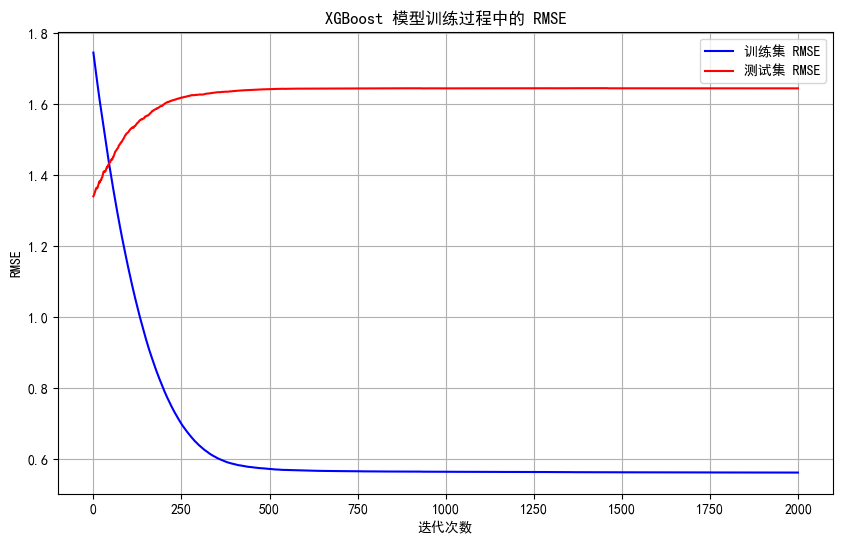

In [10]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

# 创建 DMatrix 对象
all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重

# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=100,
    evals_result=evals_result,
    verbose_eval=500
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:2.99171


[500]	train-rmse:0.32359


[1000]	train-rmse:0.31418


[1500]	train-rmse:0.31281


[1999]	train-rmse:0.31168


全部数据 MSE: 0.1024, 全部数据 R²: 0.9894


Gap between last actual value and first prediction: 1.8191333129882814


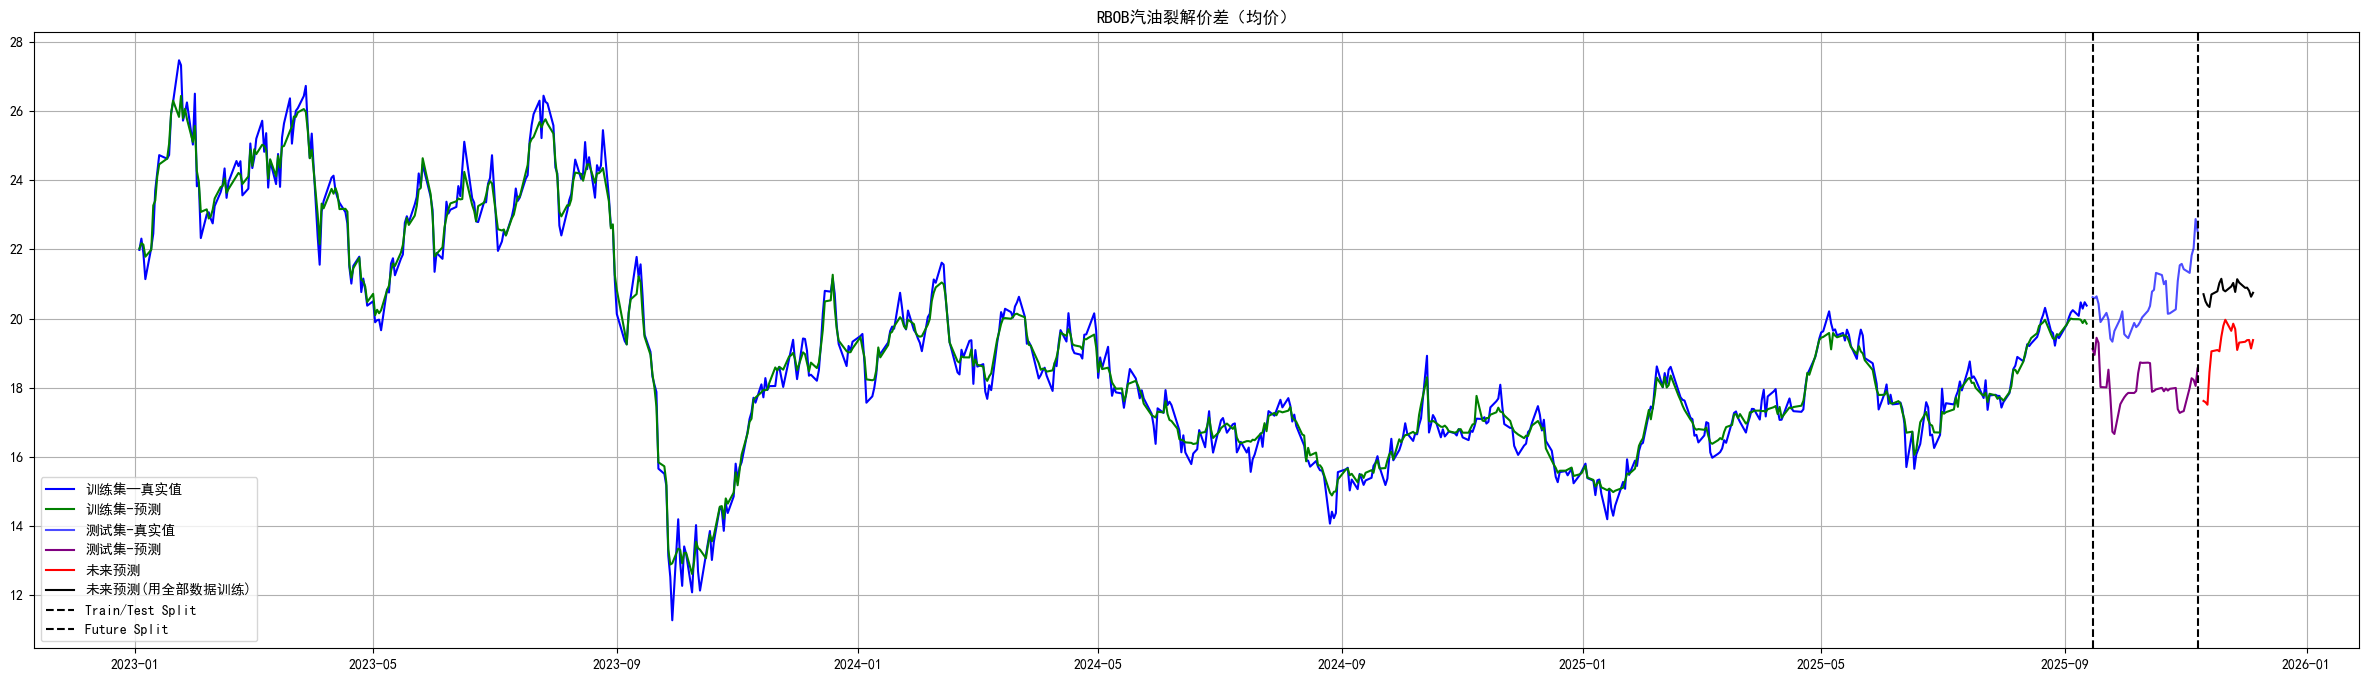

In [12]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
future_data = plot_predictions(y_test, future_data, col=True, label=True)

# 过滤2023年之后的数据
mask_train = pd.to_datetime(train_data['Date']) >= '2023-01-01'
mask_test = pd.to_datetime(test_data['Date']) >= '2023-01-01'
mask_future = pd.to_datetime(future_data['Date']) >= '2023-01-01'

plt.plot(train_data.loc[mask_train, 'Date'], y_train[mask_train], label='训练集—真实值', color='blue')
plt.plot(train_data.loc[mask_train, 'Date'], y_train_pred_dmatrix[mask_train], label='训练集-预测', color='green')
plt.plot(test_data.loc[mask_test, 'Date'], y_test[mask_test], label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data.loc[mask_test, 'Date'], y_test_pred_dmatrix[mask_test], label='测试集-预测', color='purple')
plt.plot(future_data.loc[mask_future, 'Date'], future_data.loc[mask_future, '预测值'], label='未来预测', color='red')
plt.plot(future_data.loc[mask_future, 'Date'], future_data.loc[mask_future, '预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('RBOB汽油裂解价差（均价）')
plt.legend()
plt.grid(True)
plt.show()

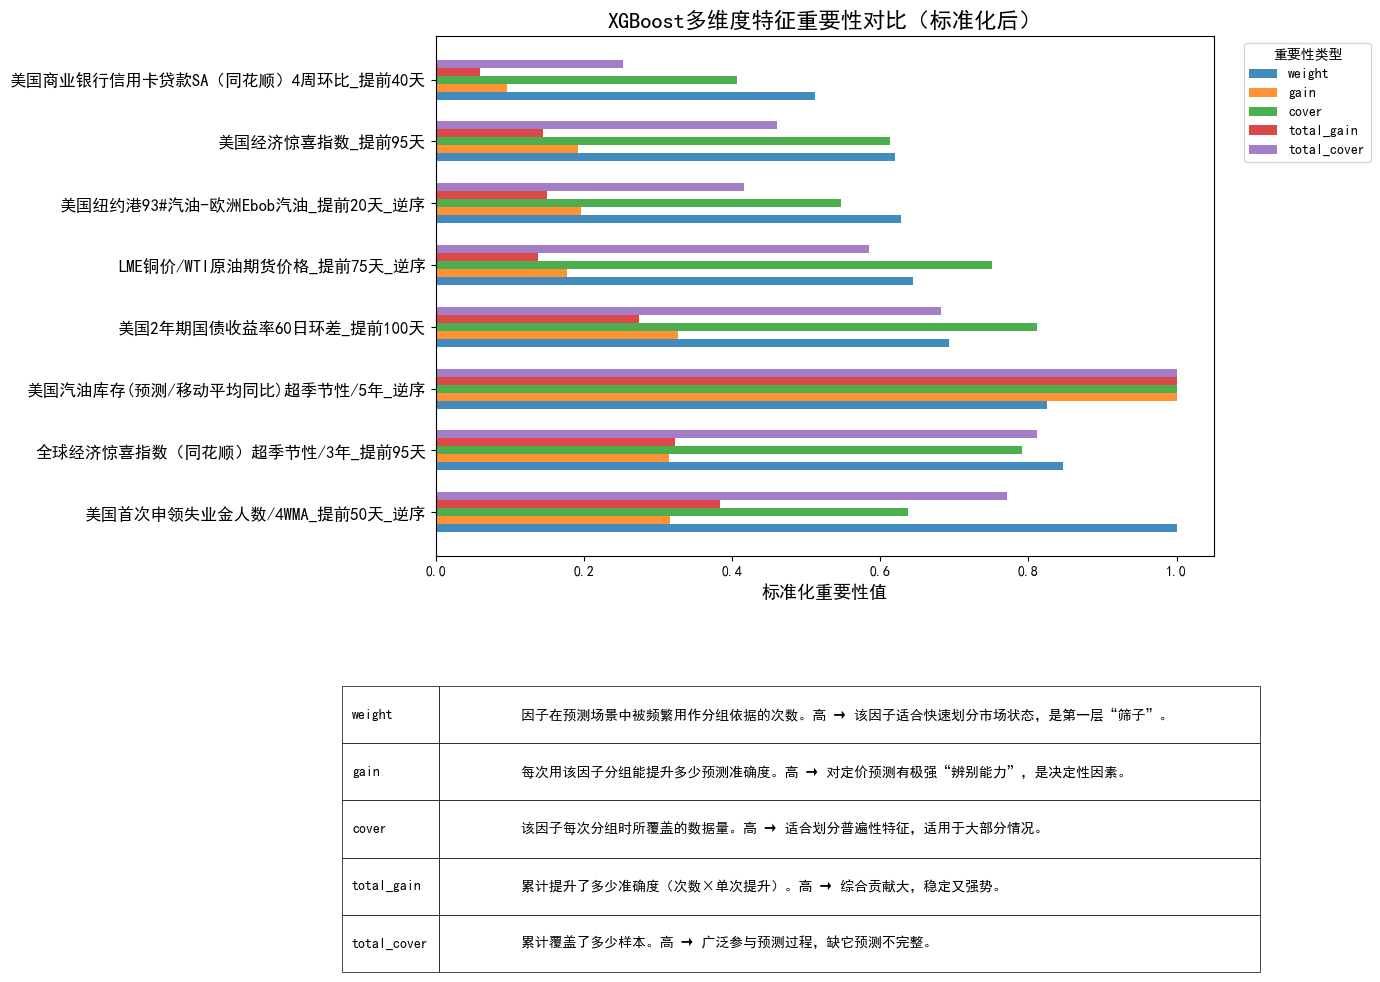

,weight,gain,cover,total_gain,total_cover
美国首次申领失业金人数/4WMA_提前50天_逆序,1.000000,0.316465,0.636930,0.383292,0.771429
全球经济惊喜指数（同花顺）超季节性/3年_提前95天,0.846605,0.314778,0.791841,0.322767,0.811939
美国汽油库存(预测/移动平均同比)超季节性/5年_逆序,0.825650,1.000000,1.000000,1.000000,1.000000
美国2年期国债收益率60日环差_提前100天,0.692791,0.326565,0.812176,0.274016,0.681486
LME铜价/WTI原油期货价格_提前75天_逆序,0.643755,0.176801,0.750187,0.137851,0.584917
美国纽约港93#汽油-欧洲Ebob汽油_提前20天_逆序,0.628248,0.196714,0.546650,0.149683,0.415954
美国经济惊喜指数_提前95天,0.620285,0.192192,0.613126,0.144388,0.460623
美国商业银行信用卡贷款SA（同花顺）4周环比_提前40天,0.512154,0.096684,0.406553,0.059973,0.252187


In [13]:

#绘制因子重要性
plot_xgb_feature_importance(model_all, X_train)



---

In [14]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/RBOB汽油裂解价差（均价）_合并数据.xlsx', index=False,float_format='%.1f')

merged_df_daily

,Date,真实值,预测值
736,2025/12/05,NaN,20.744577
735,2025/12/04,NaN,20.631435
734,2025/12/03,NaN,20.806234
733,2025/12/02,NaN,20.892931
732,2025/12/01,NaN,20.887411
...,...,...,...
4,2023/01/09,22.0490,NaN
3,2023/01/06,21.1398,NaN
2,2023/01/05,21.8982,NaN
1,2023/01/04,22.3108,NaN


In [15]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.round(2)
# 保存成excel
merged_df_monthly.to_excel('eta/RBOB汽油裂解价差（均价）_月度数据.xlsx', index=False, float_format='%.1f')

merged_df_monthly

,Date,真实值,预测值
35,2025/12/31,NaN,20.790001
34,2025/11/30,22.12,20.160000
33,2025/10/31,20.47,17.959999
32,2025/09/30,20.14,18.900000
31,2025/08/31,19.14,19.110001
30,2025/07/31,17.90,17.770000
29,2025/06/30,17.00,17.120001
28,2025/05/31,19.26,19.080000
27,2025/04/30,17.85,17.760000
26,2025/03/31,16.78,16.910000


In [16]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "RBOB汽油裂解价差（均价）"   

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [17]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "RBOB汽油裂解价差（均价）"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
